In [1]:
import numpy as np
import pandas as pd
import cymetric as cym
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, '../../transition-scenarios/scripts/')
import transition_metrics as tm

In [3]:
out_file = "d3ploy_test.sqlite"

In [4]:
evaler = tm.get_metrics(out_file)
energy = tm.get_annual_electricity(out_file)

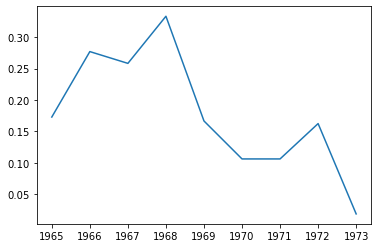

In [5]:
plt.plot(energy['Year'], energy['Energy'])

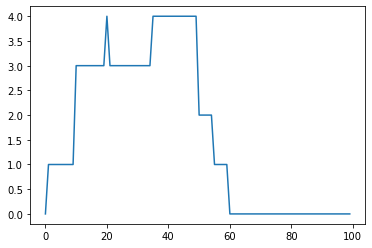

In [6]:
non_lwr = ['source', 'sink', 'Advanced Reactor', 
           'LWR Deployment', 'sink_source_facilities',
           'SingleRegion', 'source_inst']
reactors = tm.rx_commission_decommission(out_file, non_lwr)
plt.plot(reactors['Time'], reactors['lwr_total'])

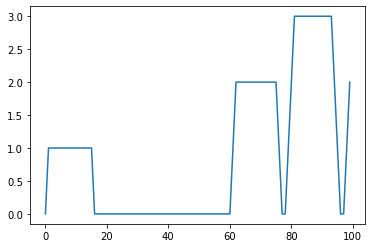

In [7]:
advrx_numbers = tm.prototype_totals(out_file, non_lwr, ['Advanced Reactor'])
plt.plot(advrx_numbers['Time'], advrx_numbers['advrx_total'])

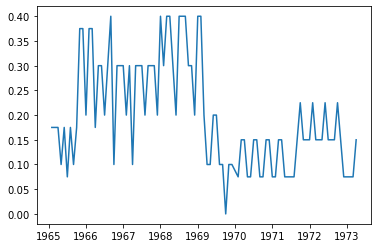

In [11]:
monthly_energy = tm.get_monthly_electricity(out_file)
#energy
plt.plot(monthly_energy['Year'], monthly_energy['Energy'])
t = np.linspace(0,100,100)
#plt.plot(t/12+1965, t, 'k')
plt.savefig('d3ploy_test_monthly_energy.png')